# $\chi^2$ fit with Chase+2017

## In this Notebook we explore the Chase+2017 approach to analyzing IOPs

## Specifically, we perform multi-Gaussian fits to absorption spectra

## We find the solutions "blow-up", i.e. the covariance matrix is ill-defined.  And this is on a "mini" model where only the amplitudes of the Gaussians can vary (wavelength and $\sigma$ are fixed).

## See the companion Notebook for a Bayesian (MCMC) analysis

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.utils import plotting
from bing.models import anw as bing_anw

import anly_utils
import fit_anw

In [2]:
%matplotlib ipympl

# defs

In [17]:
def show_fit(model, model_anw, p0, fit_lbl, fsize=15.):
    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    atotal = model.eval_anw(p0).flatten()
    ax.plot(model.wave, atotal, 'r-', label=fit_lbl)
    ax.plot(model.wave, model_anw, 'k-', label='True')
    # Individual components
    adg = model.eval_adg(p0).flatten()
    ax.plot(model.wave, adg, 'b:', label=r'$a_{\rm dg}$')

    # Gaussians
    agauss = atotal-adg
    ax.plot(model.wave, agauss, 'g:', label='Gaussians')
    
    ax.legend(fontsize=fsize-2)
    # 
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel(r'$a_{\rm nw} \; \rm [m^{-1}]$')
    plotting.set_fontsize(ax, fsize)
    plt.show()

# Fit with a constrained version of the Chase+2017 model

## Under the hood, the code:

1. Loads up the Loisel+2023 spectrum with the index given (the first example is 170)
2. Processes to a given satellite, as desired (we use the L23 data as is here)
3. Preps the model
4. Fits with MCMC or $\chi^2$.  Here we use $\chi^2$ to keep it simple
5. Returns the solution

## Load the model to inspect it

In [4]:
mini_name = 'Chase2017Mini'
mini_model = bing_anw.init_model(mini_name, np.linspace(350., 700, 350))
#
mini_model.nparam

12

In [5]:
mini_model.pnames

['CNAP',
 'SNAP',
 'CCDOM',
 'SCDOM',
 'aph384',
 'aph413',
 'aph435',
 'aph461',
 'aph464',
 'aph490',
 'aph532',
 'aph583']

## 12 parameters: 

### 2 each for NAP and CDOM

### One amplitude for each of the 8 Gaussians

In [6]:
reload(fit_anw)
#model, model_anw, p0, ans, cov = fit_anw.fit('Chase2017', 170, None,True use_chisq=True, max_wave=600.)
model, model_anw, p0, ans, cov = fit_anw.fit(
    'Chase2017Mini', 170, None,
    show=False, use_chisq=True, nsteps=20000, max_wave=600.,
    abs_noise=0.005, chk_guess=False, min_wave=400.)

## We remind ourselves that the NAP and CDOM components are both exponentials

### For NAP, the shape parameter is forced to lie in the interval $S_{\rm NAP} = [0.005, 0.016]$

### For CDOM, the shape parameter is $S_{\rm CDOM} = [0.005, 0.02]$

# Show the initial guess, $p0$

In [7]:
p0

array([-2.05596171, -2.04845501, -2.        , -2.        , -2.05596171,
       -2.05596171, -2.05596171, -2.05596171, -2.05596171, -2.05596171,
       -2.05596171, -2.05596171])

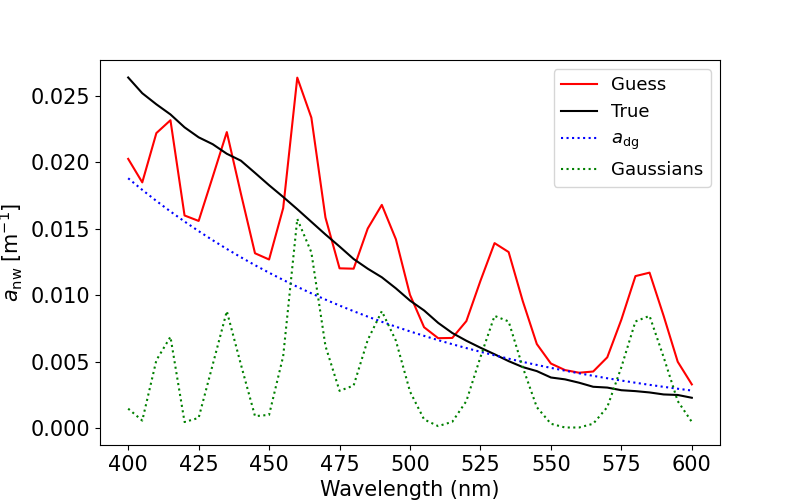

In [16]:
show_fit(model, model_anw, p0, 'Guess')

# Show the fit

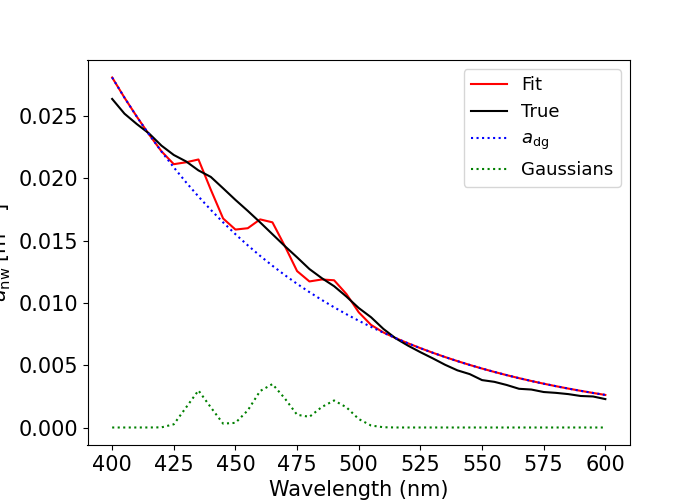

In [9]:
show_fit(model, model_anw, ans, 'Fit')

# At this level of inspection, all looks well and good

## But the devil is in the details, or really in the error estimates..

## Let's examine the covariance matrix generated by the LM ($\chi^2$) fitting

## Diagonal

In [10]:
perr = np.sqrt(np.diag(cov))
perr

array([7.90453826e+06, 1.05361028e+03, 4.75546569e+06, 6.15461978e+02,
       5.12949281e+03, 2.89921522e+02, 1.56898897e-01, 3.73360381e+02,
       1.95161953e-01, 1.82899641e-01, 3.47081555e+02, 3.83181785e+02])

## Percent error

In [11]:
perc_err = np.abs(100*perr / ans)
perc_err

array([3.99900181e+08, 5.47228504e+04, 2.70820976e+08, 3.19653908e+04,
       8.54921759e+04, 5.15065720e+03, 6.20951763e+00, 6.56213871e+03,
       7.95569999e+00, 6.86586675e+00, 5.78991349e+03, 6.39076110e+03])

## Yes, that is $100000000$% error for several of these and $1000$% for others

## We should have anticipated that the NAP and CDOM components would be highly uncertain because they have nearly the same shape.

## But many of the Gaussians are extremely uncertain too

## Show the covariance array

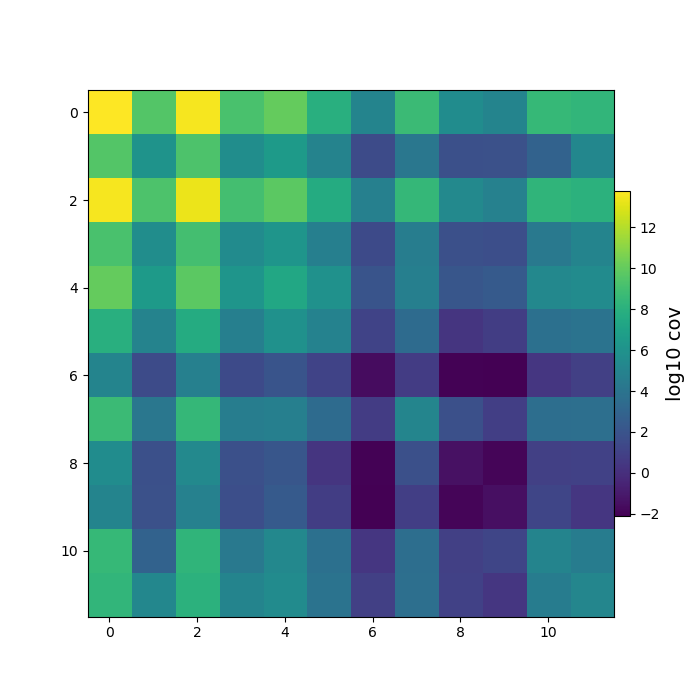

In [14]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
img = ax.imshow(np.log10(np.abs(cov)))
cbaxes = plt.colorbar(img, pad=0., fraction=0.030)
cbaxes.set_label('log10 cov', fontsize=14)
#
plt.show()

In [13]:
cov

array([[ 6.24817251e+13, -3.47727998e+09, -3.75897605e+13,
        -1.71558562e+09,  1.07014365e+10,  8.15729835e+07,
         1.10358086e+05, -5.17055914e+08,  4.07861379e+05,
         1.18468415e+05, -3.31431752e+08, -2.11733150e+08],
       [-3.47727998e+09,  1.11009462e+06,  2.09197366e+09,
        -4.55900004e+05, -3.50997890e+06, -9.79660435e+04,
         3.40582236e+01, -1.44087698e+04,  5.56438592e+01,
         6.67675906e+01,  7.55911197e+02, -1.79439216e+05],
       [-3.75897605e+13,  2.09197366e+09,  2.26144539e+13,
         1.03211701e+09, -6.43811358e+09, -4.90752989e+07,
        -6.63927582e+04,  3.11067081e+08, -2.45374330e+05,
        -7.12720271e+04,  1.99393346e+08,  1.27381217e+08],
       [-1.71558562e+09, -4.55900004e+05,  1.03211701e+09,
         3.78793446e+05,  1.45930038e+06,  5.39582872e+04,
        -2.72136063e+01,  4.01740588e+04, -5.83255388e+01,
        -4.73815866e+01,  1.97472612e+04,  1.20851197e+05],
       [ 1.07014365e+10, -3.50997890e+06, -6.4381135